In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

from symfit import variables, parameters, Fit, D, ODEModel
from symfit.core.minimizers import DifferentialEvolution, BasinHopping

from ode_sys import *

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Data

In [2]:
# data derived with the WebPlotDigitizer
t_3 = np.array([3, 6, 9, 10, 11, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32])
od6 = np.array([.023, .09, .36, .59, .98, 1.19, 1.41, 1.64, 2.24, 2.56, 3.24, 4.13, 5.02, 5.09, 5.23, 5.28])

# invented data for a and m
t_in = np.array([    3,    6,    9,   10,   11,    12,   14,   16,   18,   20,   22,   24,   26,   28,   30,   32])
y_in = np.array([ .023,  .09,  .36,  .59,  .98,  1.19, 1.41, 1.64, 2.24, 2.56, 3.24, 4.13, 5.02, 5.09, 5.23, 5.28])
a_in = np.array([.0046, .018, .072, .118, .196,  .238,  .28,  .41,  .88, 1.28, 2.11,  2.9,  3.5,  3.5,  3.4,  3.2])
m_in = np.array([.0207, .081, .324, .531, .882, 1.071, 1.27, 1.48, 1.98, 2.18, 2.55,  2.9,  3.2,  3.1,  2.9, 2.64])
# data when the cell is not starving (s=0)
t0_in = t_in[:7]
y0_in = y_in[:7]
a0_in = a_in[:7]
m0_in = m_in[:7]
data0_in = np.array([t0_in, y0_in, a0_in, m0_in])
# data when glucose is depleted -> starvation (s=1)
t1_in = t_in[6:]
y1_in = y_in[6:]
a1_in = a_in[6:]
m1_in = m_in[6:]

# starvation-data derived with the single cell model
# starvation
t1_sc = np.array([  14,   16,   18,   20,   22,   24,   26,   28,   30,   32])
y1_sc = np.array([1.41, 1.64, 2.24, 2.56, 3.24, 4.13, 5.02, 5.09, 5.23, 5.28])
a1_sc = np.array([ .28,  .42,  .69,  .92, 1.30, 1.81, 2.34, 2.46, 2.59, 2.64])
m1_sc = np.array([1.27, 1.41, 1.85, 2.03, 2.49, 3.08, 3.64, 3.59, 3.60, 3.55])
data1_sc = np.array([t1_sc, y1_sc, a1_sc, m1_sc])
# whole data
t_sc = np.concatenate((t0_in, t1_sc[1:]), axis=0)
y_sc = np.concatenate((y0_in, y1_sc[1:]), axis=0)
a_sc = np.concatenate((a0_in, a1_sc[1:]), axis=0)
m_sc = np.concatenate((m0_in, m1_sc[1:]), axis=0)

# Derive data for the multi-cell model

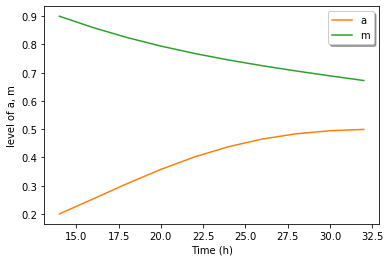

In [3]:
# parameters
a1, a2 = .2, .3
b, d = .04, .032
params = [a1, a2, b, d]
# initial values
a_0 = .2
m_0 = .9
x0 = [a_0, m_0]

# call solver
sol_sc = solve_ivp(sc1_1, [14, 32], x0, t_eval = np.linspace(14, 32, 10),
                   method='BDF', args=(params,))

plt.plot(sol_sc.t, sol_sc.y[0], label='a', color=colors[1])
plt.plot(sol_sc.t, sol_sc.y[1], label='m', color=colors[2])
plt.xlabel('Time (h)')
plt.ylabel('level of a, m')
plt.legend(shadow=True)

plt.show()

In [4]:
# scale with the cell densities
print(np.round(sol_sc.y[0]*y1_in, 2)) # = a1_sc
print(np.round(sol_sc.y[1]*y1_in, 2)) # = m1_sc

[0.28 0.42 0.69 0.92 1.3  1.81 2.34 2.46 2.59 2.64]
[1.27 1.41 1.85 2.03 2.49 3.08 3.64 3.59 3.6  3.55]


# Fitting the first multi-cell model

## Fit with different initial values (log. and gen. log. growth)

In [6]:
y, y1, t = variables('y, y1, t')
K, r, K1, r1, n1 = parameters('K, r, K1, r1, n1')

K.min, K.max, K.value = 1.47, 1.72, 1.5
r.min, r.max, r.value = .54, .92, .7
K1.min, K1.max, K1.value = 1.41, 1.419, 1.44
r1.min, r1.max, r1.value = 1.38, 1.59, 1.5
n1.min, n1.max, n1.value = 2.4, 3.4, 3.1

model_dict_l = {
    D(y, t): r*y*(1-y/K),
}

model_dict_g = {
    D(y1, t): r1/n1*y1*(1-(y1/K1)**n1),
}

i=0
ode_model_l0 = ODEModel(model_dict_l, initial={t: t0_in[i], y: y0_in[i]})
ode_model_g0 = ODEModel(model_dict_g, initial={t: t0_in[i], y1: y0_in[i]})
i=1
ode_model_l1 = ODEModel(model_dict_l, initial={t: t0_in[i], y: y0_in[i]})
ode_model_g1 = ODEModel(model_dict_g, initial={t: t0_in[i], y1: y0_in[i]})
i=2
ode_model_l2 = ODEModel(model_dict_l, initial={t: t0_in[i], y: y0_in[i]})
ode_model_g2 = ODEModel(model_dict_g, initial={t: t0_in[i], y1: y0_in[i]})
i=3
ode_model_l3 = ODEModel(model_dict_l, initial={t: t0_in[i], y: y0_in[i]})
ode_model_g3 = ODEModel(model_dict_g, initial={t: t0_in[i], y1: y0_in[i]})

fit_l0 = Fit(ode_model_l0, t=t0_in, y=y0_in, minimizer=DifferentialEvolution)
fit_g0 = Fit(ode_model_g0, t=t0_in, y1=y0_in, minimizer=DifferentialEvolution)
fit_l1 = Fit(ode_model_l1, t=t0_in, y=y0_in, minimizer=DifferentialEvolution)
fit_g1 = Fit(ode_model_g1, t=t0_in, y1=y0_in, minimizer=DifferentialEvolution)
fit_l2 = Fit(ode_model_l2, t=t0_in, y=y0_in, minimizer=DifferentialEvolution)
fit_g2 = Fit(ode_model_g2, t=t0_in, y1=y0_in, minimizer=DifferentialEvolution)
fit_l3 = Fit(ode_model_l3, t=t0_in, y=y0_in, minimizer=DifferentialEvolution)
fit_g3 = Fit(ode_model_g3, t=t0_in, y1=y0_in, minimizer=DifferentialEvolution)

fit_result_l0 = fit_l0.execute()
fit_result_g0 = fit_g0.execute()
fit_result_l1 = fit_l1.execute()
fit_result_g1 = fit_g1.execute()
fit_result_l2 = fit_l2.execute()
fit_result_g2 = fit_g2.execute()
fit_result_l3 = fit_l3.execute()
fit_result_g3 = fit_g3.execute()

# to compute the rss
y_l0 = ode_model_l0(t=t0_in, **fit_result_l0.params)[0]
y_l1 = ode_model_l1(t=t0_in, **fit_result_l1.params)[0]
y_l2 = ode_model_l2(t=t0_in, **fit_result_l2.params)[0]
y_l3 = ode_model_l3(t=t0_in, **fit_result_l3.params)[0]
y_g0 = ode_model_g0(t=t0_in, **fit_result_g0.params)[0]
y_g1 = ode_model_g1(t=t0_in, **fit_result_g1.params)[0]
y_g2 = ode_model_g2(t=t0_in, **fit_result_g2.params)[0]
y_g3 = ode_model_g3(t=t0_in, **fit_result_g3.params)[0]

# for the plot
t_plot = np.linspace(3,14, 89)
y_l0_p = ode_model_l0(t=t_plot, **fit_result_l0.params)[0]
y_l1_p = ode_model_l1(t=t_plot, **fit_result_l1.params)[0]
y_l2_p = ode_model_l2(t=t_plot, **fit_result_l2.params)[0]
y_l3_p = ode_model_l3(t=t_plot, **fit_result_l3.params)[0]
y_g0_p = ode_model_g0(t=t_plot, **fit_result_g0.params)[0]
y_g1_p = ode_model_g1(t=t_plot, **fit_result_g1.params)[0]
y_g2_p = ode_model_g2(t=t_plot, **fit_result_g2.params)[0]
y_g3_p = ode_model_g3(t=t_plot, **fit_result_g3.params)[0]

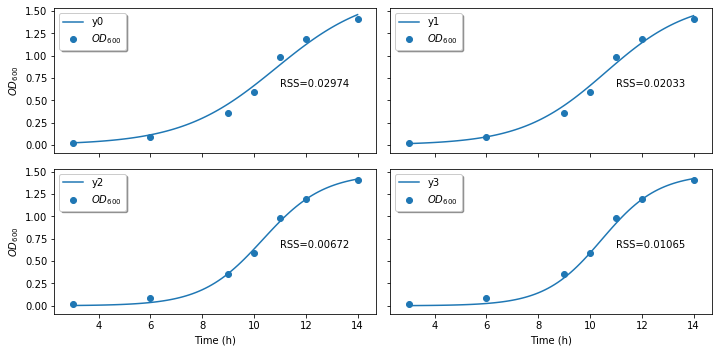

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)

axs[0,0].plot(t_plot, y_l0_p, label='y0')
axs[0,0].scatter(t0_in, y0_in, label='$OD_{600}$')
axs[0,0].text(11, 0.65, 'RSS='+str(np.round(np.sum((y_l0-y0_in)**2), 5)))
axs[0,0].legend(shadow=True)

axs[0,1].plot(t_plot, y_l1_p, label='y1')
axs[0,1].scatter(t0_in, y0_in, label='$OD_{600}$')
axs[0,1].text(11, 0.65, 'RSS='+str(np.round(np.sum((y_l1-y0_in)**2), 5)))
axs[0,1].legend(shadow=True)

axs[1,0].plot(t_plot, y_l2_p, label='y2')
axs[1,0].scatter(t0_in, y0_in, label='$OD_{600}$')
axs[1,0].text(11, 0.65, 'RSS='+str(np.round(np.sum((y_l2-y0_in)**2), 5)))
axs[1,0].legend(shadow=True)

axs[1,1].plot(t_plot, y_l3_p, label='y3')
axs[1,1].scatter(t0_in, y0_in, label='$OD_{600}$')
axs[1,1].text(11, 0.65, 'RSS='+str(np.round(np.sum((y_l3-y0_in)**2), 5)))
axs[1,1].legend(shadow=True)

plt.setp(axs[1, :], xlabel='Time (h)')
plt.setp(axs[:, 0], ylabel='$OD_{600}$')

plt.tight_layout()
#plt.savefig('only_y.pdf')
plt.show()

In [4]:
#print(fit_result_l2.params)

In [7]:
# parameters
K, r = 1.4801439740721747, .849793431417659 
g = 5
b, d = .1, .57
M = .9*K*(d-b/g) # -> m converges to .9*K
params = [r, K, g, M, b, d]

y0 = .00289816 # = y_l2[0] for one run we made
a0, m0 = .17*y0, .87*y0
x0 = [y0, a0, m0]

sol_0l = solve_ivp(m_0l, [3, 14], x0, method='LSODA', args=(params,))
# to compute the rss
sol_0l_rss = solve_ivp(m_0l, [3, 14], x0, t_eval=t0_in, method='LSODA', args=(params,))

print('RSS(y): ' + str(np.round(np.sum((sol_0l_rss.y[0]-y0_in)**2), 5)))
print('RSS(a): ' + str(np.round(np.sum((sol_0l_rss.y[1]-a0_in)**2), 5)))
print('RSS(m): ' + str(np.round(np.sum((sol_0l_rss.y[2]-m0_in)**2), 5)))

# intitial values for the starvation case
x01 = [sol_0l.y[0][-1], sol_0l.y[1][-1], sol_0l.y[2][-1]]

RSS(y): 0.00679
RSS(a): 0.0007
RSS(m): 0.00698


### fit for s=1

/home/melanie/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


OrderedDict([('K1', 44.621192151526294), ('Tm', 0.6448719469960811), ('a1', 6.0043671796840625), ('d1', 0.09183377250775487), ('r1', 0.366059967647435)])


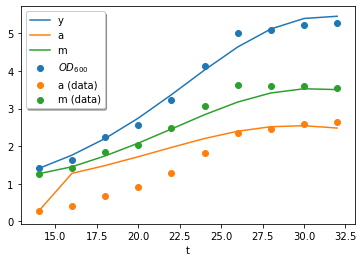

In [4]:
y, a, m, t = variables('y, a, m, t')
a1, d1, K1, r1, Tm = parameters('a1, d1, K1, r1, Tm')

a1.min, a1.max, a1.value = 6, 6.1, 6.03
d1.min, d1.max, d1.value = .08, .1, .09
K1.min, K1.max, K1.value = 44, 45, 44.8
r1.min, r1.max, r1.value = .36, .37, .364
Tm.min, Tm.max, Tm.value = .64, .65, .644

a2 = 1.526*a1
b1 = 2.145*d1

model_dict = {         
    D(y, t): r1*y*(1-y/K1)*(m-Tm*y),
    D(a, t): a1*a*(y-a)-a2*a*(y-m),
    D(m, t): b1*m*(a-d1/b1*y)
}

i=0
ode_model = ODEModel(model_dict, initial={t: t1_sc[i], y: y1_sc[i], a:a1_sc[i] , m: m1_sc[i]})

fit = Fit(ode_model, t=t1_sc, y=y1_sc, a=a1_sc, m=m1_sc, minimizer=DifferentialEvolution)
fit_result = fit.execute()
print(fit_result.params)

plot_fits(ode_model(t=t1_sc, **fit_result.params), data1_sc)

### With initial values from the first part (parameter values have to be adapted)

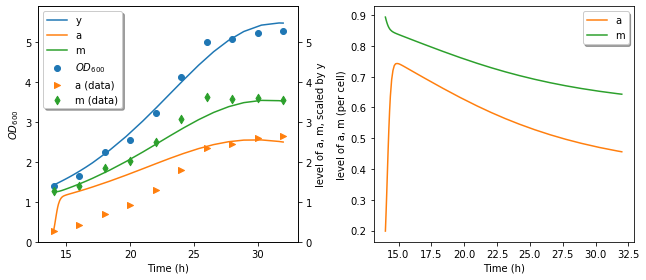

RSS(y): 0.31339
RSS(a): 2.56233
RSS(m): 0.35078


In [8]:
r1, K1, a1 = .364, 53, 6.
d1, Tm = .093, .645
a2 = 1.526*a1
b1 = 2.145*d1

params = [r1, K1, Tm, a1, a2, b1, d1]
sol_1l = solve_ivp(m_1l, [14, 32], x01, 'LSODA', args=(params,))
#to compute the RSS
sol_1l_rss = solve_ivp(m_1l, [14, 32], x01, t_eval=t1_sc, method='LSODA', args=(params,))

plot_solutions(sol_1l, data1_sc)

rss_1l = np.round(np.sum((sol_1l_rss.y-data1_sc[1:])**2, axis = 1),5)

print('RSS(y): ' + str(rss_1l[0]))
print('RSS(a): ' + str(rss_1l[1]))
print('RSS(m): ' + str(rss_1l[2]))

In [6]:
#eigenvalues of stationary point P4 with this parameter set
p4 = [K1, K1*d1/b1, K1*(1-a1/a2*(1-d1/b1))]
print(np.linalg.eig(jac_s(p4, params))[0])

[ 9.83746343e+00 -1.58089212e+02 -1.00258554e-01]


# With gen. log. growth

## Consider first only Y

In [3]:
y, t = variables('y, t')
r, n, K = parameters('r, n, K')

#non-starvation case
model_dict_l = {
    D(y, t): r*y*(1-y/K)
}
model_dict_g = {
    D(y, t): r/n*y*(1-(y/K)**n)
}

ode_model_g0 = ODEModel(model_dict_g, initial={t: t_3[2], y: od6[2]})
ode_model_l0 = ODEModel(model_dict_l, initial={t: t_3[2], y: od6[2]})
ode_model_g1 = ODEModel(model_dict_g, initial={t:t_3[6], y:od6[6]})
ode_model_l1 = ODEModel(model_dict_l, initial={t:t_3[6], y:od6[6]})

fit_l0 = Fit(ode_model_l0, t=t_3[0:7], y=od6[0:7])
fit_l1 = Fit(ode_model_l1, t=t_3[6:], y=od6[6:])
fit_g0 = Fit(ode_model_g0, t=t_3[0:7], y=od6[0:7])
fit_g1 = Fit(ode_model_g1, t=t_3[6:], y=od6[6:])

fit_result_l0 = fit_l0.execute()
fit_result_l1 = fit_l1.execute()
fit_result_g0 = fit_g0.execute()
fit_result_g1 = fit_g1.execute()

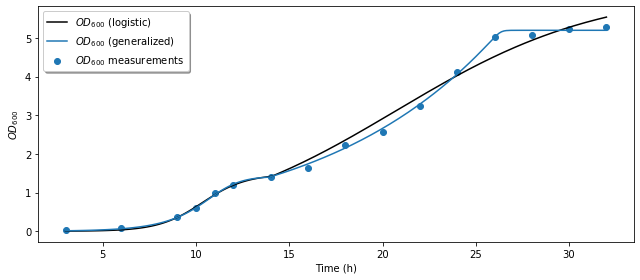

In [19]:
y_l0 = ode_model_l0(t=np.linspace(3, 14, 89), **fit_result_l0.params)
y_l1 = ode_model_l1(t=np.linspace(14, 32, 145), **fit_result_l1.params)
y_g0 = ode_model_g0(t=np.linspace(3, 14, 89), **fit_result_g0.params)
y_g1 = ode_model_g1(t=np.linspace(14, 32, 145), **fit_result_g1.params)

plt.figure(figsize=(9,4))

plt.xlabel('Time (h)')
plt.ylabel('$OD_{600}$')
plt.scatter(t_3, od6, color=colors[0], marker='o', label='$OD_{600}$ measurements')

plt.plot(np.linspace(3, 14, 89), y_l0[0], color='black', label='$OD_{600}$ (logistic)')
plt.plot(np.linspace(14, 32, 145), y_l1[0], color='black')
plt.plot(np.linspace(3, 14, 89), y_g0[0], color=colors[0], label='$OD_{600}$ (generalized)')
plt.plot(np.linspace(14, 32, 145), y_g1[0], color=colors[0])

plt.tick_params(axis='y')
plt.legend(shadow=True)
plt.tight_layout()
#plt.savefig('only_y_gen.pdf')
plt.show()

## Compare different initial points again

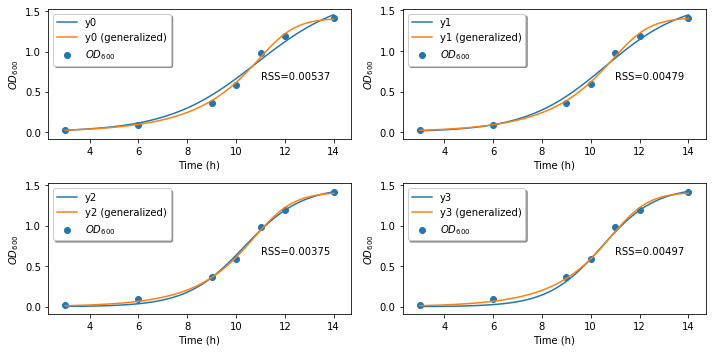

In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(2,2,1)
plt.plot(t_plot, y_l0_p, label='y0')
plt.plot(t_plot, y_g0_p, label='y0 (generalized)')
plt.scatter(t0_in, y0_in, label='$OD_{600}$')
#plt.xticks(tdata1)
plt.xlabel('Time (h)')
plt.ylabel('$OD_{600}$')
plt.text(11, 0.65, 'RSS='+str(np.round(np.sum((y_g0-y0_in)**2), 5)))
plt.legend(shadow=True)

plt.subplot(2,2,2)
plt.plot(t_plot, y_l1_p, label='y1')
plt.plot(t_plot, y_g1_p, label='y1 (generalized)')
plt.scatter(t0_in, y0_in, label='$OD_{600}$')
#plt.xticks(tdata1)
plt.xlabel('Time (h)')
plt.ylabel('$OD_{600}$')
plt.text(11, 0.65, 'RSS='+str(np.round(np.sum((y_g1-y0_in)**2), 5)))
plt.legend(shadow=True)

plt.subplot(2,2,3)
plt.plot(t_plot, y_l2_p, label='y2')
plt.plot(t_plot, y_g2_p, label='y2 (generalized)')
plt.scatter(t0_in, y0_in, label='$OD_{600}$')
#plt.xticks(tdata1)
plt.xlabel('Time (h)')
plt.ylabel('$OD_{600}$')
plt.text(11, 0.65, 'RSS='+str(np.round(np.sum((y_g2-y0_in)**2), 5)))
plt.legend(shadow=True)

plt.subplot(2,2,4)
plt.plot(t_plot, y_l3_p, label='y3')
plt.plot(t_plot, y_g3_p, label='y3 (generalized)')
plt.scatter(t0_in, y0_in, label='$OD_{600}$')
#plt.xticks(tdata1)
plt.xlabel('Time (h)')
plt.ylabel('$OD_{600}$')
plt.text(11, 0.65, 'RSS='+str(np.round(np.sum((y_g3-y0_in)**2), 5)))
plt.legend(shadow=True)

plt.tight_layout()
#plt.savefig('only_y_g.pdf')
plt.show()

In [27]:
#print(fit_result_g2.params)

## s=0

OrderedDict([('b', 0.027119816280501044), ('d', 0.4999102779221031), ('g', 5.000388043815747)])


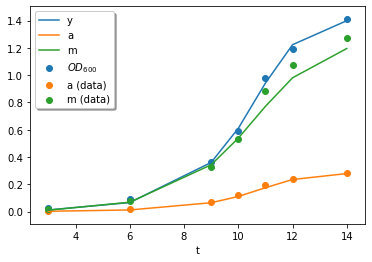

In [36]:
y, a, m, t = variables('y, a, m, t')
g, M, b, d = parameters('g, M, b, d')

g.min, g.max, g.value = 4.95, 5.05, 5
b.min, b.max, b.value = .027, .03, .029
d.min, d.max, d.value = .46, .5, .48

K = 1.413931678779375
r = 1.3819066797483224  
n = 2.429362977019412

M = .9*K*(d-b/g)

model_dict = {         
    D(y, t): r/n*y*(1-(y/K)**n),
    D(a, t): y-g*a,
    D(m, t): M*y+b*m*(a-d/b*y)
}

y0g = .01203952 #=y_g2[0]
a0g = .18*y0g
m0g = .86*y0g

ode_model = ODEModel(model_dict, initial={t: t0_in[0], y: y0g, a:a0g, m: m0g})

fit = Fit(ode_model, t=t0_in, y=y0_in, a=a0_in, m=m0_in, minimizer=DifferentialEvolution)
fit_result = fit.execute()
print(fit_result.params)

plot_fits(ode_model(t=t0_in, **fit_result.params), data0_in)

## Adapt the values for g, b and d by hand, such that m does not exceed y

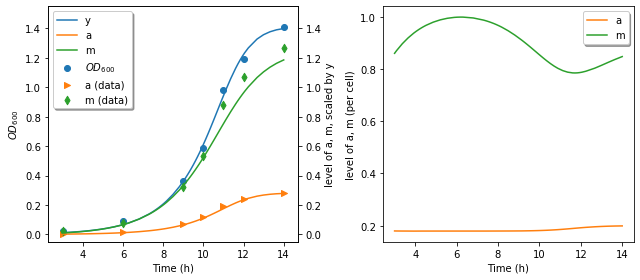

RSS(y): 0.00373
RSS(a): 0.00059
RSS(m): 0.03598


In [9]:
#parameters
#with third point was initial value
r, n, K = 1.3819066797483224, 2.429362977019412, 1.413931678779375
g = 5
b, d = .029, .48
M = .9*K*(d-b/g) #-> m converges to .9*K
params_0g = [r, n, K, g, M, b, d]
#initial values
y0g = .01203952 #=y_g2[0]
a0g, m0g = .18*y0g, .86*y0g
x0g = [y0g, a0g, m0g]

sol_0g = solve_ivp(m_0g, [3, 14], x0g, method='LSODA', args=(params_0g,))
sol_0g_rss = solve_ivp(m_0g, [3, 14], x0g, t_eval=t0_in, method='LSODA', args=(params_0g,))

plot_solutions(sol_0g, data0_in, s=0)

print('RSS(y): ' + str(np.round(np.sum((sol_0g_rss.y[0]-y0_in)**2), 5)))
print('RSS(a): ' + str(np.round(np.sum((sol_0g_rss.y[1]-a0_in)**2), 5)))
print('RSS(m): ' + str(np.round(np.sum((sol_0g_rss.y[2]-m0_in)**2), 5)))

x01g = [sol_0g.y[0][-1], sol_0g.y[1][-1], sol_0g.y[2][-1]]

## s=1

OrderedDict([('K1', 57.480244197250805), ('Tm', 0.6680344245294811), ('a1', 19.95814341850238), ('a2', 35.96958385957488), ('b1', 0.2077155559141718), ('d1', 0.08469766332330853), ('n1', 1.9505605242045247), ('r1', 0.8158707268945165)])


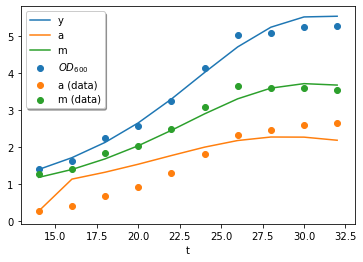

In [41]:
y, a, m, t = variables('y, a, m, t')
a1, a2, b1, d1, K1, n1, r1, Tm = parameters('a1, a2, b1, d1, K1, n1, r1, Tm')

a1.min, a1.max, a1.value = 19.9, 20.1, 20
a2.min, a2.max, a2.value = 35, 36, 35.5
b1.min, b1.max, b1.value = .19, .21, .2
d1.min, d1.max, d1.value = .075, .085, .08
K1.min, K1.max, K1.value = 57, 59, 58
n1.min, n1.max, n1.value = 1.8, 2, 1.9
r1.min, r1.max, r1.value = .76, 77, .765
Tm.min, Tm.max, Tm.value = .66, .67, .665

model_dict1 = {         
    D(y, t): r1/n1*y*(1-(y/K1)**n1)*(m-Tm*y),
    D(a, t): a1*a*(y-a)-a2*a*(y-m),
    D(m, t): b1*m*(a-d1/b1*y)
}

ode_model1 = ODEModel(model_dict1, initial={t: t1_sc[0], y: x01g[0], a:x01g[1], m: x01g[2]})

fit1 = Fit(ode_model1, t=t1_sc, y=y1_sc, a=a1_sc, m=m1_sc, minimizer=DifferentialEvolution)
fit_result1 = fit1.execute()
print(fit_result1.params)

plot_fits(ode_model1(t=t1_sc, **fit_result1.params), data1_sc)

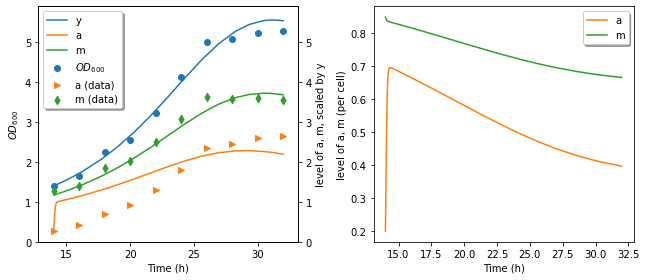

RSS(y): 0.32372
RSS(a): 1.91856
RSS(m): 0.22307


In [10]:
#parameters (of one run)
r1, n1 = .8158707268945165, 1.9505605242045247
K1, Tm = 57.480244197250805, .6680344245294811
a1, a2 = 19.95814341850238, 35.96958385957488
b1, d1 = .2077155559141718, .08469766332330853
params_1g = [r1, n1, K1, Tm, a1, a2, b1, d1]

sol_1g = solve_ivp(m_1g, [14, 32], x01g, method='LSODA', args=(params_1g,))
sol_1g_rss = solve_ivp(m_1g, [14, 32], x01g, t_eval=t1_sc, method='LSODA', args=(params_1g,))

plot_solutions(sol_1g, data1_sc)

rss_1g = np.round(np.sum((sol_1g_rss.y-data1_sc[1:])**2, axis = 1),5)

print('RSS(y): ' + str(rss_1g[0]))
print('RSS(a): ' + str(rss_1g[1]))
print('RSS(m): ' + str(rss_1g[2]))

### try with scipy minimize and custom objective function instead

In [11]:
params0 = [.8158707268945165, 1.9505605242045247, 57.480244197250805, .6680344245294811,
           19.95814341850238, 35.96958385957488, .2077155559141718, .08469766332330853]

bnds = ((.75, .82), (1.7, 2), (56, 59), (.6, .7), (19, 21), (35, 37), (.1, .3), (.07, .09))

res = minimize(residual_m, params0, args=(t1_sc, data1_sc[1:,:], x01g), bounds=bnds)

res.x

array([ 0.81570673,  1.94896191, 57.46757584,  0.66521046, 19.94995054,
       35.97842182,  0.21027698,  0.0851718 ])

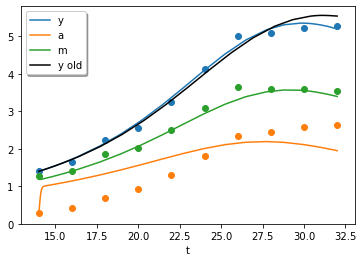

RSS(y): 0.15248
RSS(a): 2.43485
RSS(m): 0.1812


In [12]:
sol_1g2 = solve_ivp(m_1g, [14, 32], x01g, method='LSODA', args=(res.x,))
sol_1g2_rss = solve_ivp(m_1g, [14, 32], x01g, t_eval=t1_sc, method='LSODA', args=(res.x,))

y_1g2, a_1g2, m_1g2 = sol_1g2.y[0:3]
plt.plot(sol_1g2.t, y_1g2, label='y')
plt.plot(sol_1g2.t, a_1g2, label='a')
plt.plot(sol_1g2.t, m_1g2, label='m')
plt.plot(sol_1g.t, sol_1g.y[0], label='y old', color='black')
plt.scatter(t1_sc, y1_sc)
plt.scatter(t1_sc, a1_sc)
plt.scatter(t1_sc, m1_sc)
plt.ylim(0, 5.8)
plt.xlabel('t')
plt.legend(shadow=True)
plt.show()

rss_1g2 = np.round(np.sum((sol_1g2_rss.y-data1_sc[1:])**2, axis = 1),5)

print('RSS(y): ' + str(rss_1g2[0]))
print('RSS(a): ' + str(rss_1g2[1]))
print('RSS(m): ' + str(rss_1g2[2]))

# First Modification of $\dot m$ (with adaption)

OrderedDict([('K1', 5.1504559327095825), ('Ty', 0.729478490695725), ('a1', 0.9415343262812972), ('a2', 1.735527570250009), ('b1', 2.190083463019701), ('d1', 0.02439417567142572), ('r1', 4.520095995852407)])


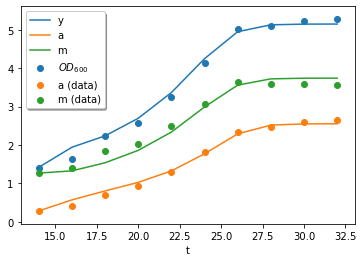

In [32]:
y, a, m, t = variables('y, a, m, t')
a1, a2, b1, d1, K1, r1, Ty = parameters('a1, a2, b1, d1, K1, r1, Ty')

a1.min, a1.max, a1.value = .94, .95, .945
a2.min, a2.max, a2.value = 1.73, 1.74, 1.735
b1.min, b1.max, b1.value = 2.15, 2.2, 2.19
d1.min, d1.max, d1.value = .02, .03, .022
K1.min, K1.max, K1.value = 5.15, 5.25, 5.2
r1.min, r1.max, r1.value = 4.5, 4.6, 4.55
Ty.min, Ty.max, Ty.value = .72, .73, .725

Tm = .672

model_dict_1d2 = {         
    D(y, t): r1*y*(1-y/K1)*(m-Tm*y),
    D(a, t): a1*a*(y-a)-a2*a*(y-m),
    D(m, t): b1*a*(Ty*y-m)-d1*m
}

ode_model_1d2 = ODEModel(model_dict_1d2, initial={t: t1_sc[0], y: x01[0], a:x01[1] , m: x01[2]})

# first : fit_mc1 = Fit(ode_model_mc1, t=ti2, y=yi2, a=ai2, m=mi2, minimizer=BasinHopping)
#  and  : fit_mc1.execute(niter=110, T=10, stepsize=.7, minimizer_kwargs={'tol': 1e-8})
# then, with adapted parameter ranges:
fit_1d2 = Fit(ode_model_1d2, t=t1_sc, y=y1_sc, a=a1_sc, m=m1_sc, minimizer=DifferentialEvolution)#BasinHopping)
fit_result_1d2 = fit_1d2.execute()
print(fit_result_1d2.params)

plot_fits(ode_model_1d2(t=t1_sc, **fit_result_1d2.params), data1_sc)

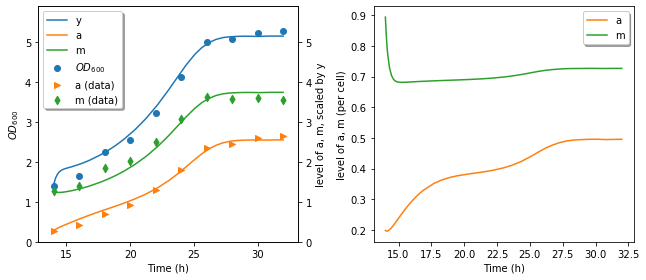

RSS(y): 0.17256
RSS(a): 0.06332
RSS(m): 0.24739


In [13]:
#parameters
r1, K1, Tm = 4.530153836535905, 5.155822859681016, .672
a1, a2 = .9420682080843957, 1.7377956657273594
b1, d1, Ty = 2.1860515775730747, .024898361992930614, .7298085885763022
params_1d2 = [r1, K1, Tm, a1, a2, b1, d1, Ty]

sol_1d2 = solve_ivp(m_1d2, [14, 32], x01, method='LSODA', args=(params_1d2,))
sol_1d2_rss = solve_ivp(m_1d2, [14, 32], x01, t_eval=t1_sc, method='LSODA', args=(params_1d2,))

plot_solutions(sol_1d2, data1_sc)

rss_1d2 = np.round(np.sum((sol_1d2_rss.y-data1_sc[1:])**2, axis = 1),5)

print('RSS(y): ' + str(rss_1d2[0]))
print('RSS(a): ' + str(rss_1d2[1]))
print('RSS(m): ' + str(rss_1d2[2]))

### Get rid of the steep increase of Y at the beginning

OrderedDict([('K1', 5.280867645485299), ('Tm', 0.8744020784044851), ('a1', 1.4238999789011126), ('a2', 9.400508438310633), ('b1', 9.336667236391088), ('d1', 0.00110927700500851), ('r1', 2.6762355307310526)])


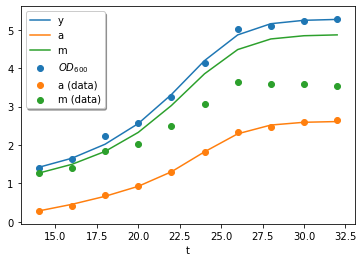

In [34]:
y, a, m, t = variables('y, a, m, t')
a1, a2, b1, d1, K1, r1, Tm = parameters('a1, a2, b1, d1, K1, r1, Tm')

a1.min, a1.max, a1.value = 1.4, 1.7, 1.6
a2.min, a2.max, a2.value = 9.3, 9.6, 9.4
b1.min, b1.max, b1.value = 9, 10.5, 10
d1.min, d1.max, d1.value = .001, .05, .03
K1.min, K1.max, K1.value = 5.2, 5.3, 5.25
r1.min, r1.max, r1.value = 1, 3.6, 3.5
Tm.min, Tm.max, Tm.value = .85, .9, .88

Ty = .215/b1-3.217*d1/b1+.901

model_dict_1d3 = {         
    D(y, t): r1*y*(1-y/K1)*(m-Tm*y),
    D(a, t): a1*a*(y-a)-a2*a*(y-m),
    D(m, t): b1*a*(Ty*y-m)-d1*m
}

ode_model_1d3 = ODEModel(model_dict_1d3, initial={t: t1_sc[0], y: x01[0], a:x01[1] , m: x01[2]})

fit_1d3 = Fit(ode_model_1d3, t=t1_sc, y=y1_sc, a=a1_sc, m=None, minimizer=BasinHopping)#DifferentialEvolution
fit_result_1d3 = fit_1d3.execute()
print(fit_result_1d3.params)

plot_fits(ode_model_1d3(t=t1_sc, **fit_result_1d3.params), data1_sc)

# Second Modification of $\dot m$

OrderedDict([('K1', 40.60567795022203), ('Tm', 0.6478753356246202), ('a1', 3.249709401562002), ('d1', 0.7475033047869786), ('r1', 1.0111026491328219)])


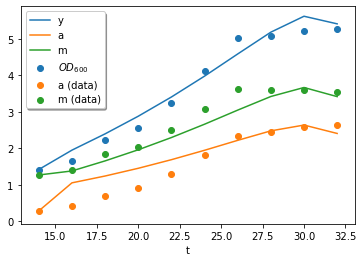

In [38]:
y, a, m, t = variables('y, a, m, t')
a1, a2, b1, d1, K1, r1, Tm = parameters('a1, a2, b1, d1, K1, r1, Tm')

a1.min, a1.max, a1.value = 3.2, 3.3, 3.23
d1.min, d1.max, d1.value = .73, .75, .734
K1.min, K1.max, K1.value = 39, 41, 40
r1.min, r1.max, r1.value = .7, 1.2, 1.1
Tm.min, Tm.max, Tm.value = .64, .65, .647

a2 = 1.526*a1
b1 = 2.145*d1

model_dict_1y = {         
    D(y, t): r1*y*(1-y/K1)*(m-Tm*y),
    D(a, t): a1*a*(y-a)-a2*a*(y-m),
    D(m, t): b1*(y-m)*(a-d1/b1*y)
}

ode_model_1y = ODEModel(model_dict_1y, initial={t: t1_sc[0], y: x01[0], a:x01[1] , m: x01[2]})

fit_1y = Fit(ode_model_1y, t=t1_sc, y=y1_sc, a=a1_sc, m=m1_sc, minimizer=DifferentialEvolution)
fit_result_1y = fit_1y.execute()
print(fit_result_1y.params)

plot_fits(ode_model_1y(t=t1_sc, **fit_result_1y.params), data1_sc)

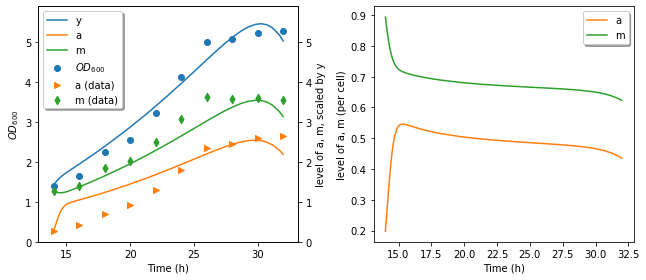

RSS(y): 0.59053
RSS(a): 1.35396
RSS(m): 0.86682


In [14]:
r1, K1, Tm = 1.0087272776202856, 40.80756726756603, .6478166024785968
a1 = 3.2217885769458685
d1 = .7497827673538797
a2 = 1.526*a1
b1 = 2.145*d1
params_1y = [r1, K1, Tm, a1, a2, b1, d1]

sol_1y = solve_ivp(m_1y, [14, 32], x01, 'LSODA', args=(params_1y,))
sol_1y_rss = solve_ivp(m_1y, [14, 32], x01, t_eval=t1_sc, method='LSODA', args=(params_1y,))

plot_solutions(sol_1y, data1_sc)

rss_1y = np.round(np.sum((sol_1y_rss.y-data1_sc[1:])**2, axis = 1),5)

print('RSS(y): ' + str(rss_1y[0]))
print('RSS(a): ' + str(rss_1y[1]))
print('RSS(m): ' + str(rss_1y[2]))

## With "-$\dot m$"

OrderedDict([('K1', 14.93470846029889), ('Tm', 0.672), ('a1', 0.1741920909034433), ('a2', 0.26027862251141193), ('b1', 0.18705182750308452), ('d1', 0.0935790357918391), ('r1', 0.3610402147878471)])


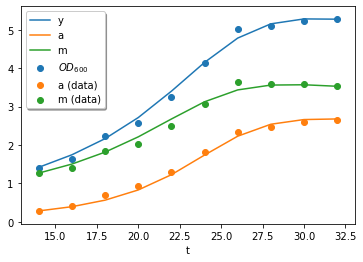

In [42]:
y, a, m, t = variables('y, a, m, t')
a1, a2, b1, d1, K1, r1, Tm = parameters('a1, a2, b1, d1, K1, r1, Tm')

a1.min, a1.max, a1.value = .17, .18, .172
a2.min, a2.max, a2.value = .26, .27, .261
b1.min, b1.max, b1.value = .18, .2, .189
d1.min, d1.max, d1.value = .09, .1, .094
K1.min, K1.max, K1.value = 14, 15, 14.45
r1.min, r1.max, r1.value = .36, .37, .367
Tm.min, Tm.max, Tm.value = .67, .68, .672
Tm.fixed = True

model_dict_m = {         
    D(y, t): r1*y*(1-y/K1)*(m-Tm*y),
    D(a, t): a1*a*(y-a)-a2*a*(y-m),
    D(m, t): b1*m*(d1/b1*y-a)
}

ode_model_m = ODEModel(model_dict_m, initial={t: t1_sc[0], y: x01[0], a:x01[1] , m: x01[2]})

fit_m = Fit(ode_model_m, t=t1_sc, y=y1_sc, a=a1_sc, m=m1_sc, minimizer=DifferentialEvolution)
fit_result_m = fit_m.execute()
print(fit_result_m.params)

plot_fits(ode_model_m(t=t1_sc, **fit_result_m.params), data1_sc)

In [46]:
r1, K1, Tm = .3610402147878471, 14.93470846029889, .672
a1, a2 = .1741920909034433, .26027862251141193
b1, d1 = .18705182750308452, .0935790357918391
params_1m = [r1, K1, Tm, a1, a2, b1, d1]

sol_1m_rss = solve_ivp(m_1m, [14, 32], x01, t_eval=t1_sc, method='LSODA', args=(params_1m,))

print('RSS(y): ' + str(np.round(np.sum((sol_1m_rss.y[0]-y1_sc)**2), 5)))
print('RSS(a): ' + str(np.round(np.sum((sol_1m_rss.y[1]-a1_sc)**2), 5)))
print('RSS(m): ' + str(np.round(np.sum((sol_1m_rss.y[2]-m1_sc)**2), 5)))

RSS(y): 0.13097
RSS(a): 0.06268
RSS(m): 0.12359


# Third Modification of $\dot m$

OrderedDict([('K1', 5.1451177320176775), ('Tm', 0.6955949700022258), ('a1', 0.5203289059728555), ('a2', 0.9407240608019246), ('b1', 3.153423608327572), ('d1', 4.346657545641074), ('r1', 6.806542006160462)])


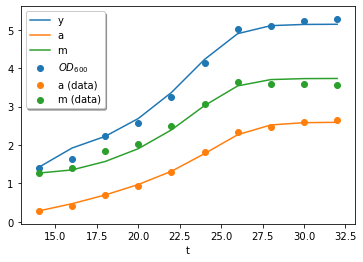

In [44]:
y, a, m, t = variables('y, a, m, t')
a1, a2, b1, d1, K1, r1, Tm = parameters('a1, a2, b1, d1, K1, r1, Tm')

a1.min, a1.max, a1.value = .51, .53, .52
a2.min, a2.max, a2.value = .9, 1, .95
b1.min, b1.max, b1.value = 2.75, 3.25, 3
d1.min, d1.max, d1.value = 4, 4.5, 4.1
K1.min, K1.max, K1.value = 5.1, 50, 30
r1.min, r1.max, r1.value = 3.4, 7, 3.5
Tm.min, Tm.max, Tm.value = .65, .70, .68

model_dict_1c = {         
    D(y, t): r1*y*(1-y/K1)*(m-Tm*y),
    D(a, t): a1*a*(y-a)-a2*a*(y-m),
    D(m, t): b1*a*(y-d1/b1*m)
}

ode_model_1c = ODEModel(model_dict_1c, initial={t: t1_sc[0], y: x01[0], a:x01[1] , m: x01[2]})

fit_1c = Fit(ode_model_1c, t=t1_sc, y=y1_sc, a=a1_sc, m=m1_sc, minimizer=DifferentialEvolution)
fit_result_1c = fit_1c.execute()
print(fit_result_1c.params)

plot_fits(ode_model_1c(t=t1_sc, **fit_result_1c.params), data1_sc)

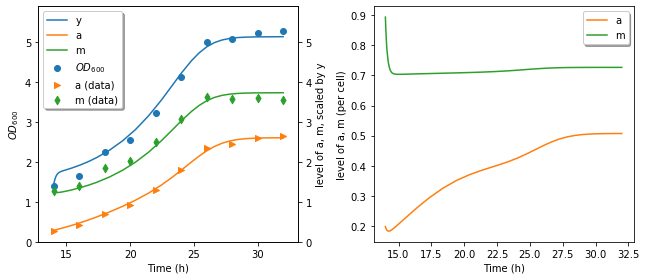

RSS(y): 0.16345
RSS(a): 0.01825
RSS(m): 0.18566


In [15]:
r1, K1, Tm = 6.607682705570198, 5.143422883668531, .69679544430603
a1, a2 = .5157881010810613, .9293444104759587
b1, d1 = 3.208759002703862, 4.414748255442791
params_1c = [r1, K1, Tm, a1, a2, b1, d1]

sol_1c = solve_ivp(m_1c, [14, 32], x01, 'LSODA', args=(params_1c,))
sol_1c_rss = solve_ivp(m_1c, [14, 32], x01, t_eval=t1_sc, method='LSODA', args=(params_1c,))

plot_solutions(sol_1c, data1_sc)

rss_1c = np.round(np.sum((sol_1c_rss.y-data1_sc[1:])**2, axis = 1),5)

print('RSS(y): ' + str(rss_1c[0]))
print('RSS(a): ' + str(rss_1c[1]))
print('RSS(m): ' + str(rss_1c[2]))

# AICc

In [16]:
rss = np.array([rss_1l, rss_1g2, rss_1d2, rss_1y, rss_1c])
rss_sum = np.sum(rss, axis = 1)
rss_sum

array([3.2265 , 2.76853, 0.48327, 2.81131, 0.36736])

In [61]:
# number of parameters for each model, including sigma
K = np.array([8, 9, 9, 8, 8])
# number of samples n = 3*10 (since we have 10 timepoints)
n = 30

In [62]:
aic = n*np.log(rss_sum/n)+2*K
aicc = aic + 2*K*(K+1)/(n-K-1)
aicc

array([ -44.03683984,  -44.48642665,  -96.85131471,  -48.16926159,
       -109.22116815])